# Peptide Retention Time Prediction using Decoder-Only Transformer – Evaluation & Test Notebook

This notebook loads a trained Decoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTDecoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np

## 2. Configuration
Set paths and model parameters (must match training!).

In [2]:
DATA_PATH = "data/mouse.txt"
MODEL_PATH = "rt_decoder_model.pt"

D_MODEL = 128
N_HEADS = 8
N_QUERIES = 3
N_LAYERS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


## 3. Load Data and Model

In [3]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=0.1, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTDecoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded.")

Model loaded.


## 4. Evaluate on Validation Set

In [4]:
all_preds, all_targets = [], []

with torch.no_grad():
    for seqs, mask, rts in val_loader:
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(rts.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Compute main metrics.

In [5]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.5f}")


Validation metrics for model:
MSE       : 0.00194
MAE       : 0.03213
R2        : 0.96529
Pearson   : 0.98275
Spearman  : 0.97673


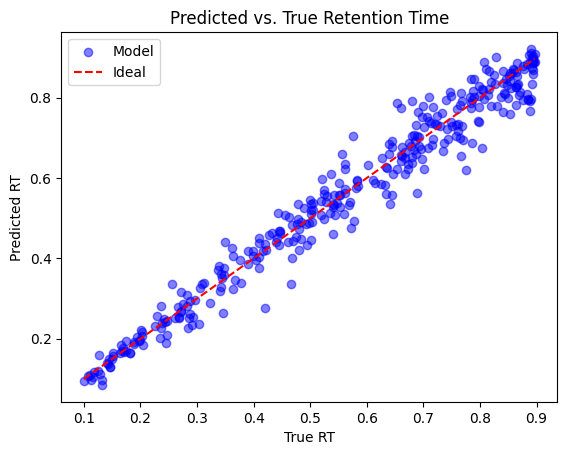

In [6]:
import matplotlib.pyplot as plt

plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

## 5. Predict RT for New Peptide Sequences
Enter your own peptide(s) below.

In [7]:
def predict_peptide_rt(peptide_seq, model, tokenizer, device):
    """
    Predict RT for a single peptide sequence (no padding, mask omitted).
    """
    model.eval()
    seq_tensor = tokenizer.encode(peptide_seq).unsqueeze(0).to(device)
    mask = torch.zeros_like(seq_tensor, dtype=torch.bool)  # all False
    with torch.no_grad():
        pred = model(seq_tensor, mask)
    return float(pred.item())

def predict_peptide_batch_rt(peptide_seqs, model, tokenizer, device):
    """
    Predict RTs for a batch of peptide sequences.
    Returns a list of floats.
    """
    model.eval()
    # Encode all sequences (list of tensors of different lengths)
    seqs = [tokenizer.encode(seq) for seq in peptide_seqs]
    # Pad to same length: (batch, max_len)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_id)
    # Mask: True where <pad>
    key_padding_mask = seqs_padded.eq(tokenizer.pad_id)
    seqs_padded, key_padding_mask = seqs_padded.to(device), key_padding_mask.to(device)
    with torch.no_grad():
        preds = model(seqs_padded, key_padding_mask)  # (batch,)
    return preds.cpu().tolist()

# Example usage:
peptides = [
    "PGGPTTTHGDASSSSNSLAEAQAPQAAPAQKPQPHPQLNK",
    "KSLPSEFEPINLR",
    "AKVAVLGASGGIGQPLSLLLK"
]

# ---- Single prediction example ----
print("Single predictions:")
for pep in peptides:
    rt_pred = predict_peptide_rt(pep, model, tokenizer, DEVICE)
    print(f"Peptide: {pep:40s}  Predicted RT: {rt_pred:.4f}")

# ---- Batch prediction example ----
print("\nBatch prediction:")
rt_preds = predict_peptide_batch_rt(peptides, model, tokenizer, DEVICE)
for pep, rt_pred in zip(peptides, rt_preds):
    print(f"Peptide: {pep:40s}  Predicted RT: {rt_pred:.4f}")

Single predictions:
Peptide: PGGPTTTHGDASSSSNSLAEAQAPQAAPAQKPQPHPQLNK  Predicted RT: 0.2618
Peptide: KSLPSEFEPINLR                             Predicted RT: 0.6271
Peptide: AKVAVLGASGGIGQPLSLLLK                     Predicted RT: 0.8307

Batch prediction:
Peptide: PGGPTTTHGDASSSSNSLAEAQAPQAAPAQKPQPHPQLNK  Predicted RT: 0.2618
Peptide: KSLPSEFEPINLR                             Predicted RT: 0.6271
Peptide: AKVAVLGASGGIGQPLSLLLK                     Predicted RT: 0.8307
